In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import ipywidgets as widgets
import cv2
from tqdm.notebook import tqdm
from czifile import CziFile

path = "../"

with CziFile(join(path, "test2.czi")) as czi:
    image_arrays = czi.asarray()
    meta = czi.metadata(raw=False)


TODO
- Calibrate h, templateWidowSize and serachWindowSize  (Denoising)
- Calibrate threshold (Thresholding)
- Understand how distances are calculated and what is the watershed marking

In [2]:
def normalize_image(img):
    img = (img/img.max())*255
    return img.astype('uint8')

def denoise_image(img, h=30):
    # Filtro mediana para eliminar ruido impulsivo
    img = cv2.medianBlur(img, 5)
    # Non-local mean denoising http://www.ipol.im/pub/art/2011/bcm_nlm/
    img = cv2.fastNlMeansDenoising(img, None, h=h, templateWindowSize=7, searchWindowSize=21)
    return img

def get_binary_mask(img):
    # Adaptive thresholding    
    binary_mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 21, 0)
    # Cerradura morfologica
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, 
                                   kernel=np.ones((3,3),np.uint8), iterations = 4)
    return binary_mask

def get_markers(dist, threshold=0.3):
    ret, sure_fg = cv2.threshold(dist, threshold*dist.max(), 255, 0)
    ret, markers = cv2.connectedComponents(sure_fg.astype('uint8'))
    return markers

<IPython.core.display.Javascript object>


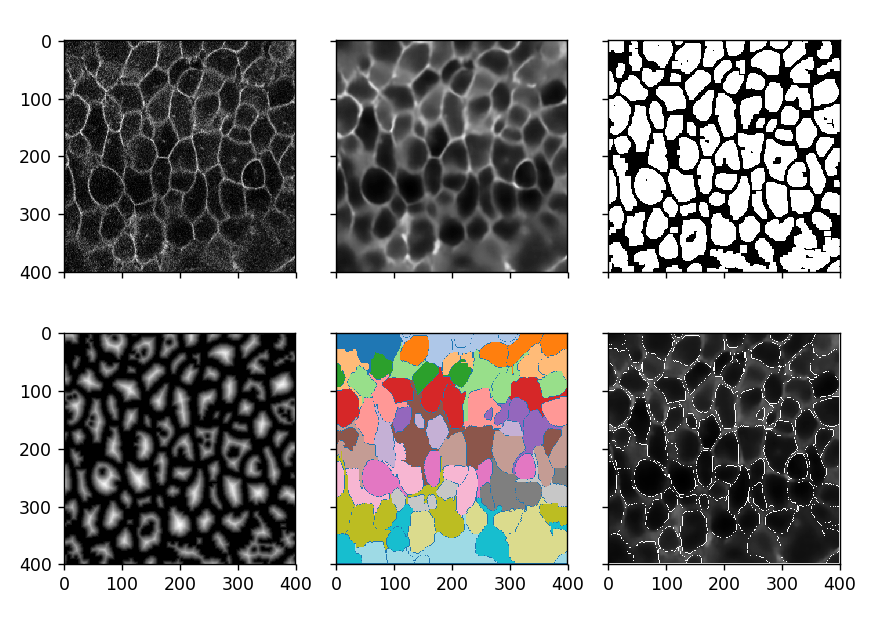

interactive(children=(IntSlider(value=0, description='k', max=59), IntSlider(value=0, description='z', max=16)…

In [3]:
fig, ax = plt.subplots(2, 3, figsize=(7, 5), tight_layout=True, sharex=True, sharey=True)

def update(k, z, h):
    img = normalize_image(image_arrays[0, 0, 0, k, z, 200:600, 200:600, 0])
    ax[0, 0].imshow(img, cmap=plt.cm.Greys_r)
    # Denoising
    img = denoise_image(img, h)
    print(img.shape)
    ax[0, 1].imshow(img, cmap=plt.cm.Greys_r)
    # Binarization
    binary_mask = ~get_binary_mask(img)
    print(binary_mask.dtype)
    ax[0, 2].imshow(binary_mask, cmap=plt.cm.Greys_r)
    # Distance transform
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
    ax[1, 0].imshow(dist_transform, cmap=plt.cm.Greys_r)
    # Watershed transform
    markers = get_markers(dist_transform, threshold=0.1)
    watershed =  cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers.copy())
    ax[1, 1].imshow(watershed, cmap=plt.cm.tab20)
    # Original with watershed borders on top
    img2 = img.copy()
    img2[watershed==-1] = 255
    ax[1, 2].imshow(img2, cmap=plt.cm.Greys_r)    
    display(np.unique(watershed))
    

widgets.interact(update, 
                 k=widgets.IntSlider(min=0, max=59),
                 z=widgets.IntSlider(min=0, max=16),
                 h=widgets.FloatSlider(min=0., max=100., value=30, step=0.01)
                 );

### Watershed de dos frames consecutivos



<IPython.core.display.Javascript object>


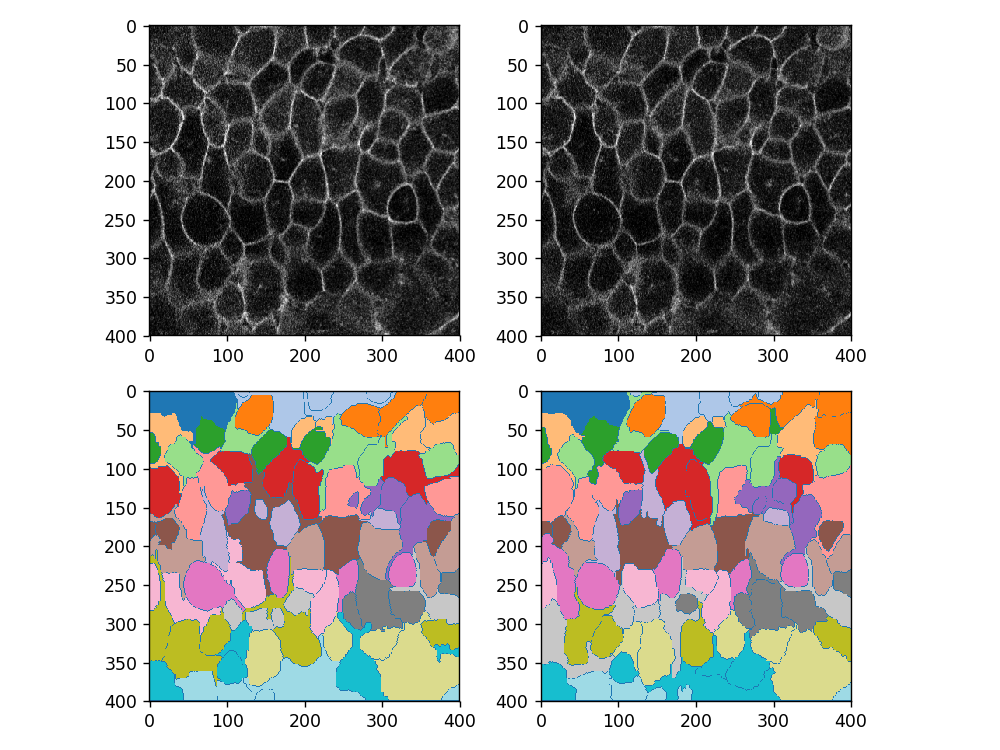

In [4]:
def watershed_pipeline(img, th=0.1):
    img = denoise_image(img)
    binary_mask = ~get_binary_mask(img)
    dist_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
    markers = get_markers(dist_transform, threshold=th)
    watershed =  cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers.copy())
    return markers, watershed

z = 0

img1 = normalize_image(image_arrays[0, 0, 0, 0, z, 200:600, 200:600, 0])
marker1, water1 = watershed_pipeline(img1)
img2 = normalize_image(image_arrays[0, 0, 0, 1, z, 200:600, 200:600, 0])
marker2, water2 = watershed_pipeline(img2)

fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
ax[0, 0].imshow(img1, cmap=plt.cm.Greys_r)
ax[0, 1].imshow(img2, cmap=plt.cm.Greys_r)
ax[1, 0].imshow(water1, cmap=plt.cm.tab20)
ax[1, 1].imshow(water2, cmap=plt.cm.tab20)


# Hacer watershed a todas las imagenes

In [5]:
img1 = normalize_image(image_arrays[0, 0, 0, 0, z, 200:600, 200:600, 0])
marker, water = watershed_pipeline(img1)
img_list = []
img_list.append(img1)
water_list = []
water_list.append(water)

for k in tqdm(range(1, 59)):
    img_list.append(normalize_image(image_arrays[0, 0, 0, k, z, 200:600, 200:600, 0]))
    marker, water = watershed_pipeline(img_list[-1], th=0.1)
    water_list.append(water)

# Medir la evolución del área de una de celula en particular

<IPython.core.display.Javascript object>


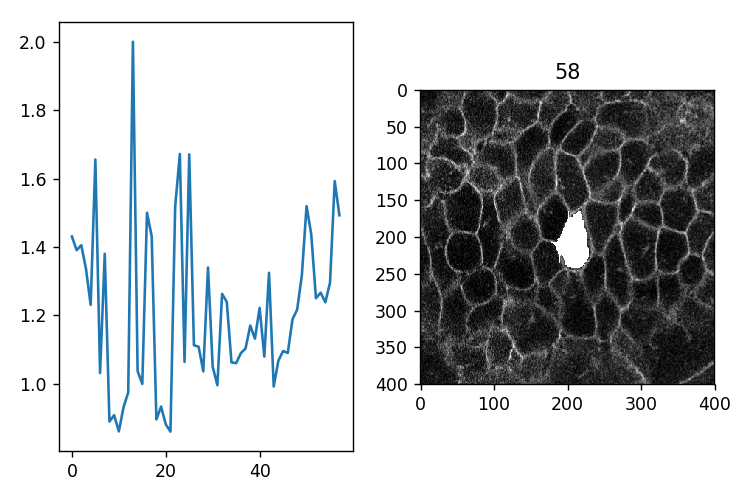

In [8]:
total_area = np.prod(water.shape)

cell_idx = 51
cell_coords = np.mean(np.where(water_list[0]==cell_idx), axis=1)
size_cell = []
cell_idx_history = [cell_idx]

for water in water_list[1:]:
    # Get coords of all cells
    new_cords = [np.mean(np.where(water==idx), axis=1) for idx in np.unique(water)[1:]]
    # Find nearest neightbor index
    closest_idx = np.argmin(np.sum((np.stack(new_cords) - cell_coords)**2, axis=1))
    nn_idx = np.unique(water)[1:][closest_idx]
    # Save index and area, agregar condiciones 
    cell_idx_history.append(nn_idx)
    size_cell.append(100*len(np.where(water == nn_idx)[0])/total_area)
    # update cell coords
    cell_coords = np.mean(np.where(water==nn_idx), axis=1)    
   
fig, ax = plt.subplots(1,2, figsize=(6, 4), tight_layout=True)
ax[0].plot(size_cell)

from matplotlib.animation import FuncAnimation

def update(k):
    ax[1].cla()
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 255
    ax[1].imshow(img, cmap=plt.cm.Greys_r)
    ax[1].set_title(k)
    
ani = FuncAnimation(fig, update, frames=range(59), repeat=False, interval=200)

In [9]:
size_cell

[1.430625,
 1.390625,
 1.405,
 1.335625,
 1.230625,
 1.655625,
 1.03125,
 1.38,
 0.889375,
 0.908125,
 0.860625,
 0.93125,
 0.974375,
 2.0,
 1.036875,
 0.999375,
 1.5,
 1.43125,
 0.895625,
 0.933125,
 0.88125,
 0.86,
 1.516875,
 1.671875,
 1.06375,
 1.670625,
 1.1125,
 1.108125,
 1.03625,
 1.34,
 1.049375,
 0.995625,
 1.2625,
 1.239375,
 1.0625,
 1.06,
 1.089375,
 1.103125,
 1.17,
 1.131875,
 1.221875,
 1.079375,
 1.324375,
 0.991875,
 1.0675,
 1.095625,
 1.09,
 1.188125,
 1.216875,
 1.3175,
 1.519375,
 1.436875,
 1.25,
 1.26625,
 1.238125,
 1.295625,
 1.5925,
 1.4925]